In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#covid_features = pd.read_csv('../content/drive/My Drive/Databases/Covid19-PreProcessed/covid_features.csv')
#normal_features = pd.read_csv('../content/drive/My Drive/Databases/Covid19-PreProcessed/normal_features.csv')
#pneumonia_features = pd.read_csv('../content/drive/My Drive/Databases/Covid19-PreProcessed/pneumonia_features.csv')

In [ ]:
#all_features = pd.concat([covid_features, normal_features, pneumonia_features])
#all_features.drop(all_features.columns[0], axis=1, inplace=True)
#all_features.to_csv("../content/drive/My Drive/Databases/Covid19-PreProcessed/all_features.csv")
all_features = pd.read_csv("../content/drive/My Drive/Databases/Covid19-PreProcessed/all_features.csv")

In [ ]:
all_features.drop(all_features.columns[0], axis=1, inplace=True)
all_features

0         1         2  ...         250       251  252
0    127581.603922  0.486696  0.249311  ...   84.212226  0.094485  0.0
1    100292.600000  0.382592  0.241244  ...  101.395351  0.114928  0.0
2    125128.792157  0.477334  0.232200  ...   29.567456  0.095783  0.0
3    159625.976471  0.608932  0.182246  ...   59.220684  0.081454  0.0
4    141615.301961  0.540417  0.224082  ...   48.174552  0.098641  0.0
..             ...       ...       ...  ...         ...       ...  ...
750  130429.913725  0.497957  0.193307  ...   41.031986  0.124442  2.0
751  141487.066667  0.539879  0.221439  ...   43.423788  0.125883  2.0
752  151746.686275  0.578923  0.231861  ...   35.217645  0.131324  2.0
753  123235.164706  0.528822  0.215215  ...  219.513703  0.089984  2.0
754  153937.811765  0.587233  0.225250  ...   34.741750  0.082173  2.0

[755 rows x 253 columns]

In [ ]:
X = all_features.iloc[:, 0:-1].values
y = all_features.iloc[:, -1].values

In [ ]:
print(X.shape)
print(y.shape)

(755, 252)
(755,)


In [ ]:
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [ ]:
from xgboost import XGBClassifier

# Create a classifier
xgb = XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=100, eval_metric="auc", num_class=3)

# Fit the classifier with the training data
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=3, objective='multi:softprob',
              random_state=100, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

# Use trained model to predict output of test dataset
y_pred = xgb.predict(X_test)

lb = preprocessing.LabelBinarizer()
lb.fit(y_test)

y_test_lb = lb.transform(y_test)
y_pred_lb = lb.transform(y_pred)

print("ROC_AUC_Score",roc_auc_score(y_test_lb, y_pred_lb, average='macro'))

ROC_AUC_Score 0.9439382564382566


In [ ]:
output = pd.DataFrame()
output['Expected Output'] = y_test
output['Predicted Output'] = y_pred
output.head()

Expected Output  Predicted Output
0              1.0               1.0
1              1.0               1.0
2              2.0               2.0
3              2.0               2.0
4              1.0               1.0

In [ ]:
# Metrics for Multilabel Classification
# https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics.md
import numpy as np
# Exact Match Ratio
MR = np.all(y_pred_lb == y_test_lb, axis=1).mean()
print("Match Ratio = ",MR)

# 0/1 Loss
loss = np.any(y_test_lb != y_pred_lb, axis=1).mean()
print("0/1Loss = ", loss)

# Accuracy
def Accuracy(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]
    
print("Accuracy = ", Accuracy(y_test_lb, y_pred_lb))

# Hamming Loss
def Hamming_Loss(y_true, y_pred):
    temp=0
    for i in range(y_true.shape[0]):
        temp += np.size(y_true[i] == y_pred[i]) - np.count_nonzero(y_true[i] == y_pred[i])
    return temp/(y_true.shape[0] * y_true.shape[1])
    
print("Hamming Loss = ", Hamming_Loss(y_test_lb, y_pred_lb))

#Precision
def Precision(y_true, y_pred):
      temp = 0
      for i in range(y_true.shape[0]):
          if sum(y_true[i]) == 0:
              continue
          temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_true[i])
      return temp/ y_true.shape[0]
print("Precision = ", Precision(y_test_lb, y_pred_lb))

# Recall
def Recall(y_true, y_pred):
      temp = 0
      for i in range(y_true.shape[0]):
          if sum(y_pred[i]) == 0:
              continue
          temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_pred[i])
      return temp/ y_true.shape[0]
print("Recall = ", Precision(y_test_lb, y_pred_lb))

# F1 Score
def F1Measure(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if (sum(y_true[i]) == 0) and (sum(y_pred[i]) == 0):
            continue
        temp+= (2*sum(np.logical_and(y_true[i], y_pred[i])))/ (sum(y_true[i])+sum(y_pred[i]))
    return temp/ y_true.shape[0]
    
print("F1 Measure = ", F1Measure(y_test_lb, y_pred_lb))
from sklearn.metrics import classification_report
# Classification Report
print("\t\t\tClassification Report")
print()
print(classification_report(y_test_lb, y_pred_lb))


Match Ratio =  0.9536423841059603
0/1Loss =  0.046357615894039736
Accuracy =  0.9536423841059603
Hamming Loss =  0.03090507726269316
Precision =  0.9536423841059603
Recall =  0.9536423841059603
F1 Measure =  0.9536423841059603
			Classification Report

              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.97      0.96      0.97        77
           2       0.92      0.97      0.95        63

   micro avg       0.95      0.95      0.95       151
   macro avg       0.97      0.92      0.94       151
weighted avg       0.95      0.95      0.95       151
 samples avg       0.95      0.95      0.95       151



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_lb.argmax(axis=1), y_pred_lb.argmax(axis=1))
print('The Confusion Matrix is:\n', cm)

The Confusion Matrix is:
 [[ 9  0  2]
 [ 0 74  3]
 [ 0  2 61]]


In [ ]:
# k-fold cross validation evaluation of xgboost model
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# CV model
model = xgboost.XGBClassifier()
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, y)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

scoring = 'roc_auc_score'
result = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)") % (results.mean(), results.std())

scoring = 'neg_mean_absolute_error'
results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
print("MAE: %.3f (%.3f)") % (results.mean(), results.std())

scoring = 'neg_mean_squared_error'
results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
print("MSE: %.3f (%.3f)") % (results.mean(), results.std())

scoring = 'r2'
results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
print("R^2: %.3f (%.3f)") % (results.mean(), results.std())

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy: 89.40% (2.33%)


ValueError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


<Figure size 432x288 with 0 Axes>

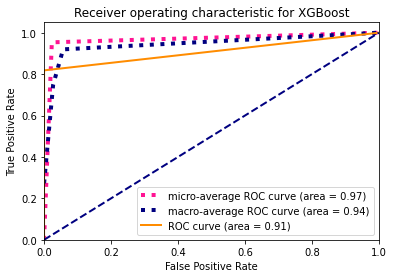

In [ ]:
from sklearn.preprocessing import label_binarize
y_binarize = label_binarize(y, classes=[0, 1, 2])
n_classes = y_binarize.shape[1]
n_classes
y_score = y_pred_lb
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_dummies.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for XGBoost')
plt.legend(loc="lower right")
plt.show()